In [2]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

def f1(real, score):
    precision, recall, thresholds = precision_recall_curve(real, score)
    f1_scores = 2*recall*precision/(recall+precision)
    return thresholds[np.argmax(f1_scores)],np.max(f1_scores)

def aucNth(y, yp, N):
    assert len(y) == len(yp)
    assert len(y) > 1
    fpr, tpr, thresholds = roc_curve(y, yp)
    negatives = y.count(0)
    assert N < negatives
    perc = N / float(negatives)
    fpr1k = []
    tpr1k = []
    i = 0
    while i < len(fpr):
        if fpr[i] > perc:
            break
        fpr1k.append(fpr[i])
        tpr1k.append(tpr[i])
        i+=1
    assert len(fpr1k) > 1
    aucScore = auc(fpr1k, tpr1k) / perc
    return aucScore

def load(fpath):
    with open(fpath,'r') as f:
        score = []
        real = []
        for l in f:
            l = l.rstrip().split()
            score.append(-float(l[2]))
            real.append(float(l[3]))
        return score,real

def layer2str(layer):
    if type(layer) == int:
        lstr = str(layer)
    else:
        lstr = ''
        for l in layer:
            if l == layer[-1]:
                lstr += '%d'%l
            else:
                lstr += '%d-'%l
    return lstr

def _stats(res):
    score,real = res
    aucScore = roc_auc_score(real, score)
    auprc = average_precision_score(real, score)
    auc1k = aucNth(real,score,1000)
    thr, f1sc = f1(real,score)
    return aucScore,auprc,auc1k,f1sc,thr

def stats(res):
    aucScore,auprc,auc1k,f1sc,thr = _stats(res)
    return '%.1f %.1f %.1f %.1f %.1f'%(aucScore*100,auprc*100,auc1k*100,f1sc*100,thr)

def loadResult(layer,n,m):
    lstr = layer2str(layer)
    allr,r = load('layer/results/allr.%s.%d.%d.res'%(lstr,n,m))
    pfamr = stats((allr[:10490],r[:10490]))
    gener = stats((allr[10490:10490+11312],r[10490:10490+11312]))
    supfr = stats((allr[10490+11312:],r[10490+11312:]))
    thr =  _stats((allr,r))[4]
    f = 0
    for i in range(len(allr)):
        if r[i] == 1 and allr[i] <= thr: f +=1
        if r[i] == 0 and allr[i] > thr: f +=1
    allr = stats((allr,r))
    return pfamr+' '+gener+' '+supfr+' '+allr+' %d'%f

def scale(v):
    M = np.max(v)
    m = np.min(v)
    return (v - m) / float(M - m)

In [3]:
n,m=5,44
lscore = []
for i in range(34):
    lscore.append(float(loadResult(i,n,m).split()[15]))
lscore=np.array(lscore)

<AxesSubplot: xlabel='ESM1b Layer', ylabel='AUROC'>

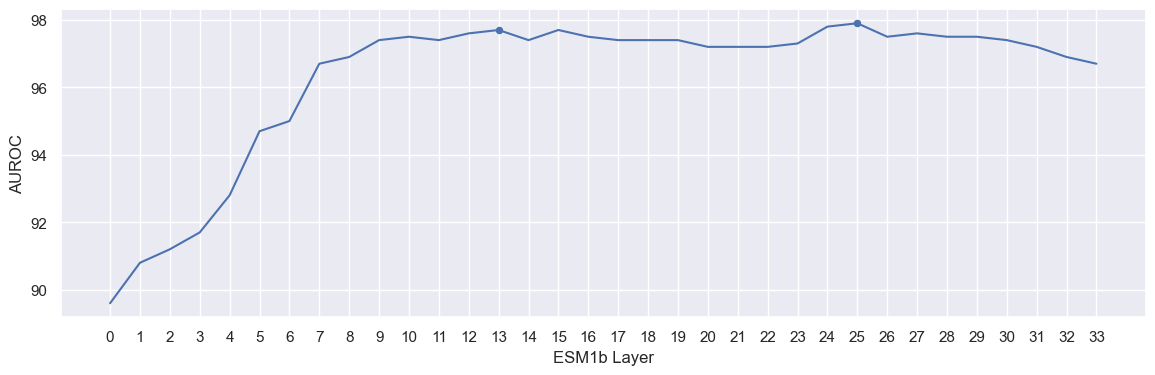

In [4]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(14,4)})
#ax = sns.heatmap(np.array(lscore).reshape(34,1),square=True)
#ax.set(xlabel='',ylabel='ESM1b Layer')
x=[i for i in range(0,34)]
ax =sns.lineplot(x=x,y=lscore)
plt.xticks(x,x)
ax.set(xlabel='ESM1b Layer',ylabel='AUROC')
sns.scatterplot(x=[13,25],y=[lscore[13],lscore[25]])
#plt.savefig('layer.png', dpi=1200)
#plt.savefig('layer.svg')

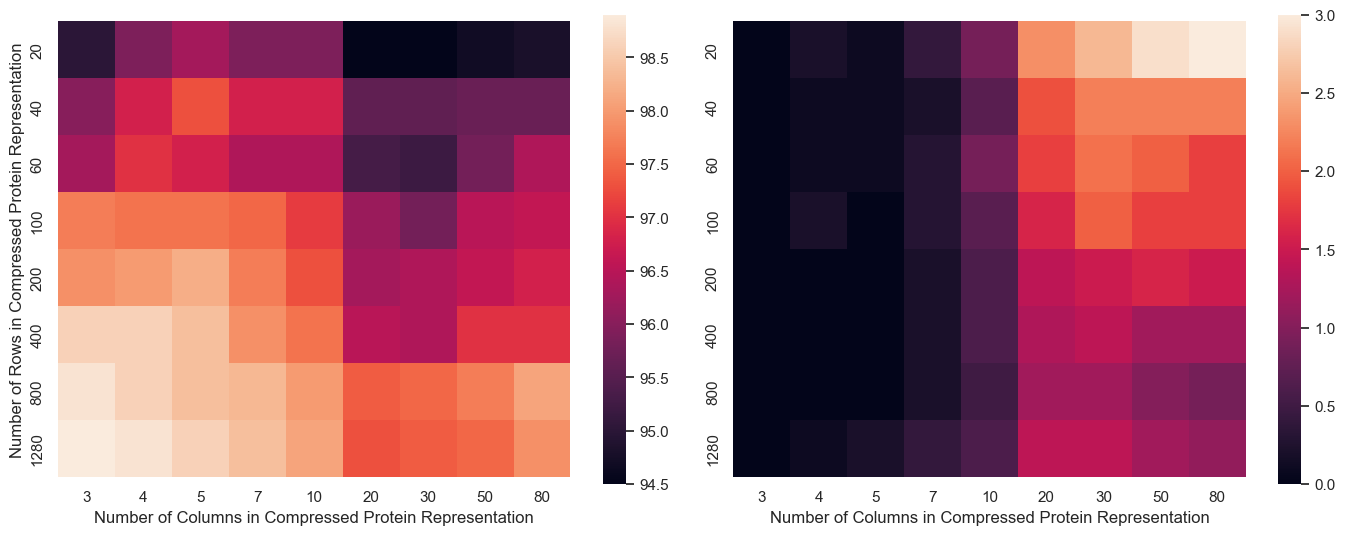

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

df3 = pd.read_csv('grid.dtw',sep=' ')
dtw = df3.pivot(index='K', columns='M', values='PA1')
df4 = pd.read_csv('grid.nodtw',sep=' ')
nodtw = df4.pivot(index='K', columns='M', values='PA1')
diff = dtw-nodtw

sns.set(rc={'figure.figsize':(14,5.3)})
fig, ax =plt.subplots(1,2)
sns.heatmap(nodtw,square=True,cmap='rocket', ax=ax[0])
ax[0].set(xlabel='Number of Columns in Compressed Protein Representation', ylabel='Number of Rows in Compressed Protein Representation')
sns.heatmap(diff,square=True,cmap='rocket', ax=ax[1])
ax[1].set(xlabel='Number of Columns in Compressed Protein Representation', ylabel='')

fig.tight_layout()
#plt.savefig('both.png', dpi=1200)
#plt.savefig('both.svg')